In [63]:
from scipy.spatial import distance
import re 
import numpy as np
import random as rand
from ripser import Rips
import matplotlib.pyplot as plt
import seaborn as sns
import statistics


In [24]:
SAMPLES = 10
SIMULATIONS = 5
GROUPS = 5
SEGSITES = 1000

### File Processing


In [25]:
"""
Collect the sequences from the different groups of simulations.

One text file consists of one group, each with different
recombination rates, but all have the same fixed mutation rate.

The function returns:
    sequences - a 4-dimensional list containing the 5 groups,
                each group with a list of 5 simulations,
                each simulation with a list of 10 samples
                in biallelic (0 and 1) format.
"""
def collect_sequences():
    fnames = ["sim_50_2.txt",
              "sim_50_4.txt",
              "sim_50_12.txt",
              "sim_50_36.txt",
              "sim_50_72.txt"]
    
    sequences = []
    sim = []
    for f in fnames:
        fp = open(f, "r")
        group = []
        for ln in fp:
            if re.match("^[01]+$", ln):
                sim.append(ln.replace("\n", ""))
                if len(sim) == SAMPLES:
                    group.append(sim)
                    sim = []
        sequences.append(group)
        fp.close()

    return sequences

### The Hamming Distance Matrix


In [26]:
"""
Collect the Hamming distance matrices across all simulations.

Parameters:
    sequences - a 4-dimensional list containing the 5 groups,
                each group with a list of 5 simulations,
                each simulation with a list of 10 samples
                in biallelic (0 and 1) format.

The function returns:
    hdmatrices - a 5-dimensional list containing the 5 groups,
                 each group with a list of 5 simulations,
                 each simulation with a numpy array containing
                 the Hamming distance matrix for 10 samples.
"""
def get_hdmatrices(sequences):
    hdmatrices = []
    for grp in sequences:
        hdm_grp = []
        for sim in grp:
            mat = np.zeros((SAMPLES, SAMPLES))
            for i in range(0, SAMPLES):
                for j in range(i, SAMPLES):
                    mat[i, j] = round(distance.hamming(
                            np.array(list(sim[i]), dtype=int),
                            np.array(list(sim[j]), dtype=int)
                        ) * SEGSITES)
                    mat[j, i] = mat[i, j]
            hdm_grp.append(mat)
        hdmatrices.append(hdm_grp)

    return hdmatrices

In [6]:
### TEST

sequences = collect_sequences()
hdmatrices = get_hdmatrices(sequences)

print(sequences)
print(len(hdmatrices))

[[['000001000101001000100001000010010000110010000100010010101110100001010111110000110110001001100000000100010010101100000000000000010010100000011001000100000000000000000000001000100001010000010000000000001001110011111000011100001001010111000000100100001010001000010100110100100000000000001101000000001010011001000000001100010000100000001000010100000000000001000000001000010110001011010010000100000000000010000010100110100100100110000100000010101000000000011100000000001011010100000101000000010001000000010010000100010000000000100000010100010101010000001001001100110101100010000001101011101010100001001100000000001010101100000000000000011000101000100001100110101011010000000000001101000000010000101000011110111011100110100000000010001100000000011011000000000011010101001000001010100010101010100011010000001000010011011101001100000010010000011101000001001000010000100000001101010010010100011000100010000110000010000000001001111110101000000000001000000100000000000000000100010001000000001010100001000001

### Sparsity

To model 'sparsity', we simply take a sample (select number of lines) from the samples of the simulation (we assume it comprises the population).

FORMAT:

sequences[group or file][simulation or sample][chromosome or line seq]


PSUEDOCODE:
1. for each simulation/sample
    - for each entry in sparsity_list
        - take a random sample of the percentage on the list
        - append this random sample to the mother list of sparse rand samples


In [27]:
""" 
Replicate sparsity in the population (i.e. simulation block).

Parameters:
    sequences - a 4-dimensional list containing the 5 groups,
                each group with a list of 5 simulations,
                each simulation with a list of 10 samples
                in biallelic (0 and 1) format.

The function returns:
    sparse_samples - a 2-dimensional list containing the 10 sampled
                    lists according to increments of 10%.

"""
def sparsity_sampling(sequences):
    sparsity_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    sparse_list = []
    

    for i in range(SIMULATIONS):
        sparse_samples = []
        for p in sparsity_list:
            sample_size = int(SAMPLES * p)
            sampled_seq = rand.sample(sequences[0][i], sample_size)
            sparse_samples.append(sampled_seq)
    sparse_list.append(sparse_samples)

    return sparse_samples

### Stochasticity

We will now add a noise matrix to the Hamming Distance Matrix to replicate stochasticity.

In [86]:
hdmatrices = get_hdmatrices(sequences)
hdmat = np.array(hdmatrices)

# to iterate over increasing values of noise variance
var_list = [round(x * 0.1,2) for x in range(0,21)]

noise_list = []
for var in var_list:
    noise_list.append(np.random.normal(0, var, hdmat.shape))

noisymat_list = []
for noise in noise_list:
    noisymat_list.append(hdmat + noise)

In [98]:
var_list

[0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0]

## Topological Qunatities


### Persistence Diagram

homologies      contains a list of three entries
                each entry is a record of birth and death times
                of each homology group ($H_0, H_1, H_2$)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)


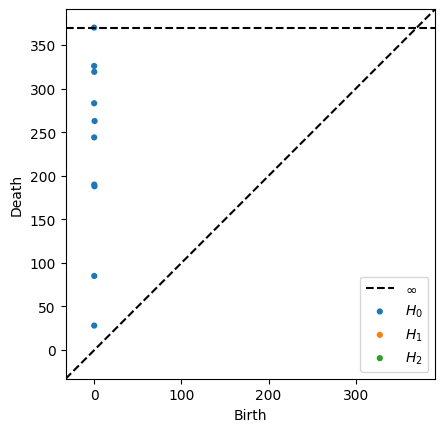

In [103]:
rips = Rips(maxdim=2, do_cocycles=True)
# Show the persistence diagram of the 5th group, 1st simulation with FIRST variance 
homologies = rips.fit_transform(noisymat_list[0][4][0], distance_matrix=True)
rips.plot(homologies, show=True)

### Betti Numbers

We note that this working code only records up to the 2nd homology group $H_2$. So, `len(homologies[0])` is the number of barcodes (or elements) in $H_0$ (first array in the list `homologies`)

In [60]:
# Compute Betti Numbers
# where bettis[k] = kth Betti number
bettis = np.array([])
for b in homologies:
    bettis = np.append(bettis, len(b))
bettis

# NOTE: This only records up to H_0 
# so len(homologies[0]) is the no. of barcodes in H_0

array([10.,  0.,  0.])

In [41]:
# Compute Barcode Lengths
# where barcode_lens[k] = H_k barcode lengths
barcode_lens = []
# for i in range(0, len(homologies)):
#     barcode_lens = np.vstack(homologies[i][:, 1] - homologies[i][:, 0]), axis=1)
for i in homologies:
    barcode_lens.append(i[:, 1] - i[:, 0])
barcode_lens

[array([  3.45364198,  29.01400769,  38.41634724,  42.63697283,
         46.95344815,  94.5218544 , 219.92024599, 251.59860629,
        611.02917141,          inf]),
 array([], dtype=float64),
 array([], dtype=float64)]

In [69]:
barcode_means = []

for lengths in barcode_lens:
    barcode_means.append(np.mean(lengths))

/Users/claire/Documents/PGC Bioinfo Training/Viral Recombination/Topo ARG/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/claire/Documents/PGC Bioinfo Training/Viral Recombination/Topo ARG/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [72]:
statistics.mean(barcode_lens[0])

np.float64(inf)

In [ ]:
# Compute Betti Number Variances
# where variances[k] = H_k barcode length variance
barcode_vars = []
for l in barcode_lens:
    barcode_vars.append(np.var(l))
barcode_vars

#### reanmed the variable for clarity since we'll be dealing with two variances here

/Users/claire/Documents/PGC Bioinfo Training/Viral Recombination/Topo ARG/env/lib/python3.12/site-packages/numpy/_core/function_base.py:168: RuntimeWarning: invalid value encountered in multiply
  y *= step


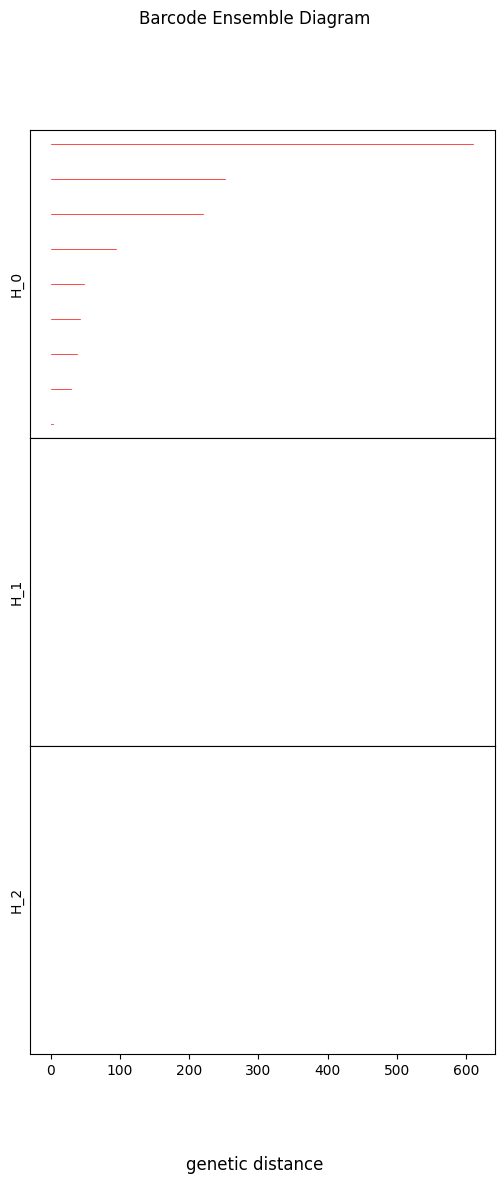

In [43]:
fig = plt.figure(figsize=(6,12))
gs = fig.add_gridspec(nrows=3,hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle("Barcode Ensemble Diagram")

colors=['r', 'b', 'g']
labels=[r'H_1', r'H_1', r'H_2']

LEN_HOMOLOGY = len(homologies)
for i in range(0, LEN_HOMOLOGY):
    axs[i].set_ylabel(f"H_{i}")
    axs[i].get_yaxis().set_ticks([])
    axs[i].label_outer()

    len_h = len(homologies[i])
    for j in range(0, len_h):
        axs[i].plot(np.linspace(homologies[i][j][0], homologies[i][j][1], 2), [j, j], c=colors[i], linewidth=0.5)
    

fig.supxlabel("genetic distance")
plt.show()